# Histogram Gradient Boosting Regressor for total shrimp weight

In this notebook, we run our models to predict total shrimp weight while only considering training data where the gear size and mesh was consistent. There are other models that have been commented out in the code, but these other architectures performed worse than HistGradBoostingRegressor.

In [1]:
## For data handling
import pandas as pd
import numpy as np

from scipy.stats import boxcox


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a dark background
sns.set_style("whitegrid")

In [2]:
#Reading in the dataset
df = pd.read_csv('../data/SHRIMP_constant_gear.csv')

#Making new columns for quartile modelling

df['CATCH_TRANSFORM'] = np.log(1+ df['TOTAL_SHRIMP_WEIGHT'])

## make a train test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, shuffle=True, random_state=216, test_size=.2)
                                                    
                                                    
## make a validation set
df_tt, df_val = train_test_split(df_train, shuffle=True, random_state=216, test_size=.2)
                                                        
                                                        
                                                        

In [3]:
#Selecting an initial set of features
# Mid salinity and air temperature are not included as they are highly correlated with max salinity and surface temperature, respectively

features = ['DEPTH_EMAX',
              'TEMPSURF', 
              'TEMPMID', 
              'SALSURF', 
              'SALMAX',
              'OXYSURF', 
              'OXYMID', 
              'OXYMAX', 
              'CHLORSURF', 
              'CHLORMID',
              'CHLORMAX',
              'TEMP_BOT',
              'DECSLAT', 
              'DECSLON',
              'YEAR', 
              'DAYOFYEAR',
              'MINUTES_SINCE_MIDNIGHT']
target = ['TOTAL_SHRIMP_WEIGHT']

##### Model Selection


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [5]:
models = {
   #'dt': DecisionTreeRegressor(),
   # 'rf': RandomForestRegressor(),
   'hgb': HistGradientBoostingRegressor()
}

In [6]:
mses = {}
for name, model in models.items():
    model.fit(df_tt[features],df_tt[target])
    mses[name] = mean_squared_error(df_val[target], model.predict(df_val[features]))

/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
mses

{'hgb': 1.3901438241851727}

## Feature Selection

In [8]:
# Determine the number of missing values in each column
missing_values = df.isnull().sum()

# Display the result
print(missing_values)

STATIONID                    0
DEPTH_EMAX                 156
TEMPSURF                   152
TEMPMID                    221
SALSURF                    186
SALMID                     258
SALMAX                     179
OXYSURF                    221
OXYMID                     267
OXYMAX                     247
CHLORSURF                  903
CHLORMID                  2678
CHLORMAX                  2321
TURBSURF                  6758
TURBMID                   6752
TURBMAX                   6765
CRUISEID                     0
FAUN_ZONE                    0
STAT_ZONE                    0
TEMP_SSURF                 127
TEMP_BOT                   202
TEMP_SAIR                  306
HAULVALUE                 3573
TIME_MIL                     0
DECSLAT                      0
DECSLON                      0
DECELAT                     63
DECELON                     63
MO_DAY_YR                    0
WAVE_HT                   1829
YEAR                         0
DAYOFYEAR                    0
SAMPLE_B

One natural question is whether our model is simply learning the map of where shrimp tend to live. We can test this by removing all the location and time aspects from the model.

In [9]:
features_env = ['DEPTH_EMAX',
              'TEMPSURF', 
              'TEMPMID', 
              'SALSURF', 
              'SALMAX',
              'OXYSURF', 
              'OXYMID', 
              'OXYMAX', 
              'CHLORSURF', 
              'CHLORMID',
              'CHLORMAX', 
              'TEMP_BOT']

In [10]:
mses_env = {}
for name, model in models.items():
    model.fit(df_tt[features_env],df_tt[target])
    mses_env[name] = mean_squared_error(df_val[target], model.predict(df_val[features_env]))

/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
mses_env

{'hgb': 2.0841267364023635}

In [12]:
#These are factors that can be measured from the surface or using existing maps, which might be easier data to collect

surface_features = ['DEPTH_EMAX',
              'TEMPSURF', 
              'SALSURF', 
              'OXYSURF', 
              'CHLORSURF', 
              'DECSLAT', 
              'DECSLON',
              'YEAR', 
              'DAYOFYEAR',
              'MINUTES_SINCE_MIDNIGHT']
target = ['TOTAL_SHRIMP_WEIGHT']

In [13]:
mses_surface = {}
for name, model in models.items():
    model.fit(df_tt[surface_features],df_tt[target])
    mses_surface[name] = mean_squared_error(df_val[target], model.predict(df_val[surface_features]))

/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
mses_surface

{'hgb': 1.473524233970758}

In [15]:
#For comparison, here is the variance of the target, which would be the mean squared error for a model that just returns the mean of the validation set

mean_shrimp_catch = df_tt['TOTAL_SHRIMP_WEIGHT'].mean()

# Predict the mean for all entries in the test set
predictions = [mean_shrimp_catch] * len(df_val)

# Calculate the MSE
mse = mean_squared_error(df_val['TOTAL_SHRIMP_WEIGHT'], predictions)

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.4884055228466515


### Model tuning

For all these subsets of features, the HistGradientBoostingRegressor was the best performing model, so we can try to tune that. First we try to visualize the trace plots to see if the model is converging.

/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


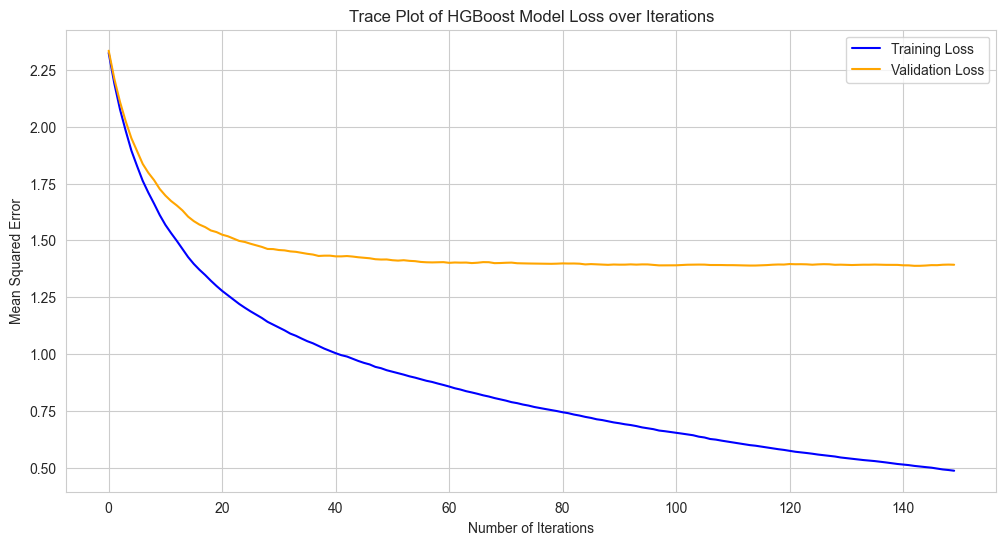

In [48]:
# Initialize the model
model = HistGradientBoostingRegressor(max_iter=150, random_state=42)

X_train = df_tt[features]
y_train = df_tt[target]

X_val = df_val[features]
y_val = df_val[target]

# Fit the model
model.fit(X_train, y_train)

# Track the loss at each stage (for both training and test sets)
train_loss = []
val_loss = []

for y_pred in model.staged_predict(X_train):
    train_loss.append(mean_squared_error(y_train, y_pred))

for y_pred in model.staged_predict(X_val):
    val_loss.append(mean_squared_error(y_val, y_pred))

# Convert the lists to numpy arrays for easier plotting
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

# Plot the trace plots
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(train_loss, label='Training Loss', color='blue')

# Plot test loss
plt.plot(val_loss, label='Validation Loss', color='orange')

# Labels and title
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Trace Plot of HGBoost Model Loss over Iterations')
plt.legend()

# Show the plot
plt.show()

In [67]:
#We can try to tune the parameters of the model. However, doing so does not really lead to improvements in the performance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import GridSearchCV

hgb = HistGradientBoostingRegressor()

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [10, 20, 30],
    'max_bins': [255, 512],
    'l2_regularization': [0.0, 1.0, 10.0],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Perform the grid search
grid_search.fit(df_train[features], df_train[target])

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # convert back to positive MSE

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_score)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/utils/val

Best Parameters: {'l2_regularization': 10.0, 'learning_rate': 0.1, 'max_bins': 255, 'max_depth': 7, 'max_iter': 150, 'min_samples_leaf': 30}
Best Mean Squared Error: 1.5078534836546198


### Prediction intervals

One question from the demo day was whether our model could be used to obtain prediction intervals for the shrimp catch. We can see that the prediction intervals generated using HistGradientBoost are a bit too narrow, but this creates a baseline for this question.

In [16]:
features_expanded = ['DEPTH_EMAX',
                    'TEMPSURF', 
                    'TEMPMID', 
                    'SALSURF', 
                    'SALMAX',
                    'OXYSURF', 
                    'OXYMID', 
                    'OXYMAX',
                    'WAVE_HT', 
                    'CHLORSURF', 
                    'CHLORMID',
                    'CHLORMAX',
                    'TURBMAX',
                    'TURBSURF',
                    'TEMP_BOT',
                    'DECSLAT', 
                    'DECSLON',
                    'YEAR', 
                    'DAYOFYEAR',
                    'MINUTES_SINCE_MIDNIGHT']

In [17]:
#New features

X_expanded_train = df_tt[features_expanded]

X_expanded_val = df_val[features_expanded]


#Applying a monotone transformation to smooth the data

y_transformed_train = df_tt['CATCH_TRANSFORM']
y_transformed_val = df_val['CATCH_TRANSFORM']

#random state

rand = 216

# Train model for lower quantile (e.g., 5th percentile)
lower_quantile = 0.05
lower_model = HistGradientBoostingRegressor(loss='quantile', quantile=lower_quantile, max_iter = 100, random_state=rand)
lower_model.fit(X_expanded_train, y_transformed_train)

# Train model for upper quantile (e.g., 95th percentile)
upper_quantile = 0.95
upper_model = HistGradientBoostingRegressor(loss='quantile', quantile=upper_quantile, max_iter = 100, random_state=rand)
upper_model.fit(X_expanded_train, y_transformed_train)

# Train model for the median (e.g., 50th percentile)
median_model = HistGradientBoostingRegressor(loss='quantile', quantile=0.5, max_iter = 100, random_state=rand)
median_model.fit(X_expanded_train, y_transformed_train)

# Make predictions
y_pred_lower = lower_model.predict(X_expanded_val)
y_pred_upper = upper_model.predict(X_expanded_val)
y_pred_median = median_model.predict(X_expanded_val)



In [18]:
# Check how many true values fall within the prediction intervals
within_interval = (y_transformed_val.to_numpy() >= y_pred_lower) & (y_transformed_val.to_numpy() <= y_pred_upper)
coverage = np.mean(within_interval)

print(f"Coverage of the prediction interval: {coverage:.2%}")

# Check how many true values fall above the lower bound
above_lower = (y_transformed_val.to_numpy() >= y_pred_lower)
lower_bound_accuracy = np.mean(above_lower)

print(f"Percent above 5% threshold: {lower_bound_accuracy:.2%}")

# Check how many true values fall below the upper bound
below_upper = (y_transformed_val.to_numpy() <= y_pred_upper)
upper_bound_accuracy = np.mean(below_upper)

print(f"Percent below 95% threshold: {upper_bound_accuracy:.2%}")


Coverage of the prediction interval: 81.44%
Percent above 5% threshold: 90.36%
Percent below 95% threshold: 91.08%
